In [1]:
from fuzzyART_gai import *
from kit_handy import *
from kit_painting import *
import matplotlib.pyplot as plt

In [2]:
data, label_true = load_data('iris') # iris, gaussian2d
pca_painter = PaintPCA(data)

Variance explained by first 2 principal components: [0.92138578 0.05142129]


In [3]:
# use FuzzyART
# init
rho = 0.6
net = FuzzyARTgai(alpha=0.5, rho=rho) # for the current iris data, rho near 0.65 seems the best in clustering data

# train
net.train(data, epochs=100) # each epoch, all data is shuffled


                (alpha, beta, gamma, rho) - changed from

                (0.5, 0.5, 0.01, 0.6) to

                (0.5, 0.5, 0.01, 0.62)
                
figure saved at _simcache/2022-04-01_15-32-18_var_testrho62


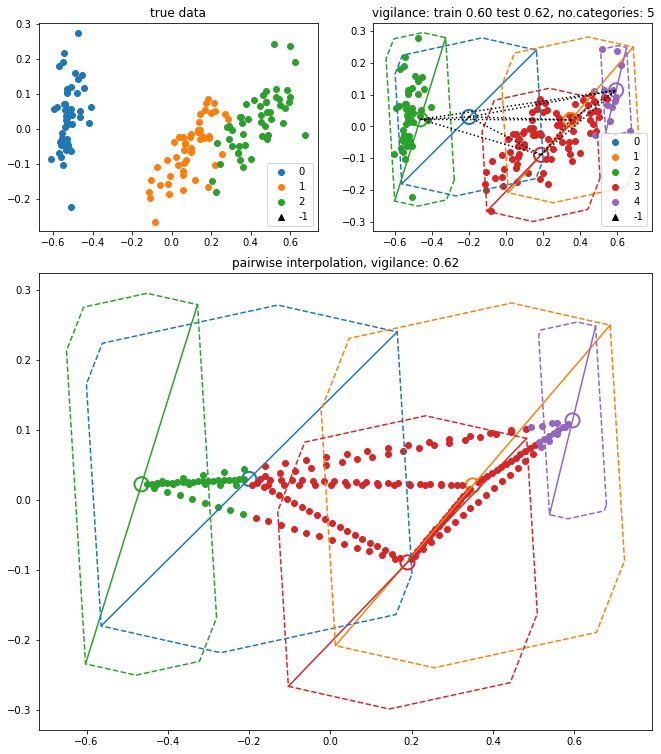

In [5]:
fig, axs = plt.subplot_mosaic("""
                                AB
                                CC
                                CC
                                """,
                                figsize=(11, 13))
#fig.tight_layout()

# plot true data
pca_painter.scatter(axs['A'], label_true)
axs['A'].set_title("true data")

no_rho = 11
ls_rho = np.linspace(0.55, 0.65, no_rho)
for test_rho in [0.62]: #ls_rho:
    for k in 'BC':
        axs[k].clear()
    
    # test
    isdiff_traintest = net._set_properties(rho = test_rho)
    label_pred = net.test(data).astype(int)

    # plot
    # pred
    pca_painter.scatter(axs['B'], label_pred, data)

    for k in 'BC':
        # bipole and centre
        pca_painter.tripole(axs[k], *net.getcat_bipole())

        # boundary    
        axs[k].set_prop_cycle(None)
        pca_painter.boundary(axs[k], net.getcat_vertex()) 

    # interpolate centres
    cat_centres = net.getcat_centre()
    pca_cat_centres = pca_painter.pca.transform(cat_centres)
    cat_number = cat_centres.shape[0]
    ls_interidx, ls_intercat = [], []
    for i in range(cat_number):
        for j in range(i + 1, cat_number):
            interidx = np.array([i, j])
            ls_interidx.append(interidx) 
            axs['B'].plot(*pca_cat_centres[interidx].T, c = 'k', ls = 'dotted')

            intercat = interp2coordinates(*cat_centres[interidx], 20)
            intercat_label = net.test(intercat).astype(int)
            ls_intercat.append(intercat_label)
            axs['C'].set_prop_cycle(None)
            pca_painter.scatter(axs['C'], intercat_label, intercat)

    # info
    axs['B'].set_title('vigilance: train {:.2f} test {:.2f}, no.categories: {}'.format(rho, test_rho, cat_number))
    axs['C'].set_title('pairwise interpolation, vigilance: {:.2f}'.format(test_rho))

    for k in 'AB':
        axs[k].legend()

    # save fig
    simname = 'var_testrho{:d}'.format(int(test_rho*100))
    dirname = '_simcache'
    savefigure_datetime(fig, simname, dirname)